# **Classifier**

In [ ]:
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.feature_extraction.text import TfidfVectorizer

import joblib
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

## **Data Loading**

In [2]:
complaints = pd.read_excel('EaUgXb.xlsx', index_col = 0)
clients = pd.read_excel('btUTgX.xlsx', index_col=0)

In [3]:
churn = clients['Churn']

In [4]:
complaints = complaints.merge(churn, left_on='customerID', right_index=True)
complaints.drop(columns=['complaint_number'], inplace=True)
complaints.rename(columns={'Churn': 'churn'}, inplace=True)
complaints['churn'] = complaints['churn'].map({'No': 0, 'Yes': 1})

In [5]:
complaints['churn'].value_counts(normalize=True)

churn
1    0.617445
0    0.382555
Name: proportion, dtype: float64

The classes are not balanced, the majority of clients who complain then churn. This however is reasonable so we will not try to rebalance the data and leave it like this. 

## **Visualization**

In this section we try to see whether visualizing the data already gives us some insight on how the data is distributed. In particular, we embed the data using TFIDF an dthen we perform dimensionality reduction using TSNE on 2 and 3 dimensions. 

In [6]:
vectorizer = TfidfVectorizer(max_features=500)  
X = vectorizer.fit_transform(complaints['complaint']).toarray()

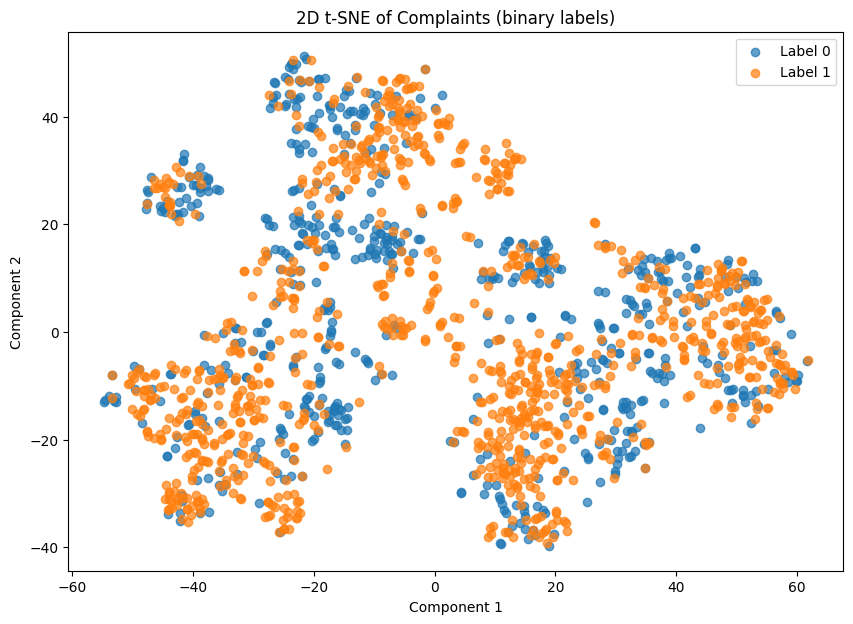

In [7]:
# 2D Visualization
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X)
plt.figure(figsize=(10, 7))
for label in [0, 1]:
    idx = complaints['churn'] == label
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=f'Label {label}', alpha=0.7)

plt.legend()
plt.title('2D t-SNE of Complaints (binary labels)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()


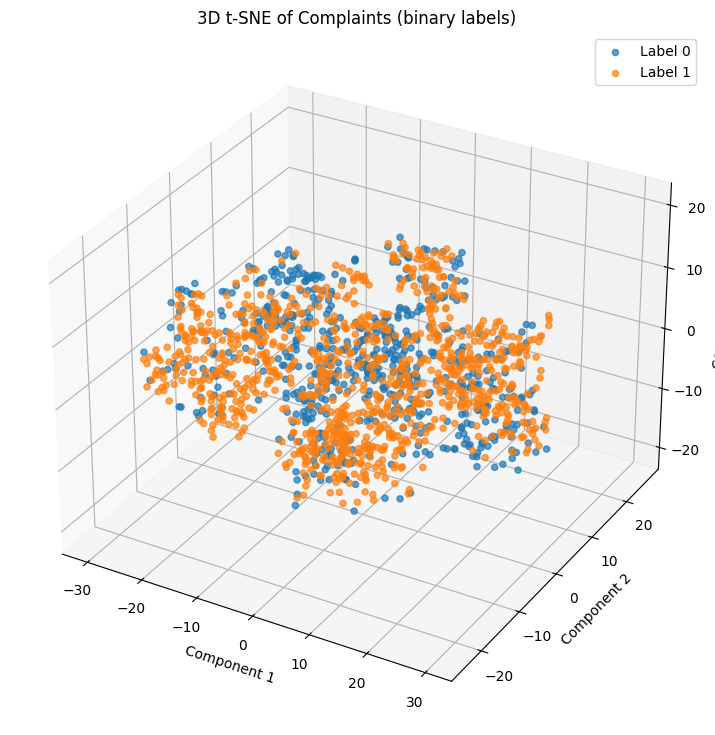

In [9]:
# 3D Visualization
tsne = TSNE(n_components=3, random_state=42)
X_embedded = tsne.fit_transform(X)
from mpl_toolkits.mplot3d import Axes3D

# Step 3: Plot
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

for label in [0, 1]:
    idx = complaints['churn'] == label
    ax.scatter(X_embedded[idx, 0], X_embedded[idx, 1], X_embedded[idx, 2], label=f'Label {label}', alpha=0.7)

ax.set_title('3D t-SNE of Complaints (binary labels)')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
ax.legend()
plt.show()

Ideally, we wanted to have two separate clusters, i.e. we aimed at having two distinct classes corresponding to comments that lead to churn and comments that don't. Unfortunately, this is not the case. Therefore, from the embedding and the visualization we don't get any insight on churn probability.

## **Classifier**
Now we build a simple classifier that, based on the complaint, tries to predict whether that client will churn or not. We try the following models:
- Logistic Regression
- CatBoost
- Random Forest
- Small Neural Network

In [10]:
y = complaints['churn'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [11]:
log = LogisticRegression(max_iter=1000)
log.fit(X_train, y_train)

y_pred = log.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7725856697819314
Confusion Matrix:
 [[ 74  49]
 [ 24 174]]
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.60      0.67       123
           1       0.78      0.88      0.83       198

    accuracy                           0.77       321
   macro avg       0.77      0.74      0.75       321
weighted avg       0.77      0.77      0.77       321



In [12]:
cboost = CatBoostClassifier(verbose=0)  
cboost.fit(X_train, y_train)

y_pred = cboost.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7850467289719626
Confusion Matrix:
 [[ 73  50]
 [ 19 179]]
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.59      0.68       123
           1       0.78      0.90      0.84       198

    accuracy                           0.79       321
   macro avg       0.79      0.75      0.76       321
weighted avg       0.79      0.79      0.78       321



In [13]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7694704049844237
Confusion Matrix:
 [[ 67  56]
 [ 18 180]]
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.54      0.64       123
           1       0.76      0.91      0.83       198

    accuracy                           0.77       321
   macro avg       0.78      0.73      0.74       321
weighted avg       0.77      0.77      0.76       321



In [14]:
# --- Prepare data ---
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# --- Define small neural network ---
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(X_train.shape[1], 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            
            nn.Linear(128, 1),
            nn.Sigmoid()  
        )
    
    def forward(self, x):
        return self.net(x)

# --- Train ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 20

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# --- Evaluation ---
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = (outputs.cpu().numpy() > 0.5).astype(int)
        y_pred.extend(preds.flatten())
        y_true.extend(labels.numpy())

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))


Epoch [1/20], Loss: 0.5814
Epoch [2/20], Loss: 0.3473
Epoch [3/20], Loss: 0.2424
Epoch [4/20], Loss: 0.1644
Epoch [5/20], Loss: 0.1445
Epoch [6/20], Loss: 0.0959
Epoch [7/20], Loss: 0.1049
Epoch [8/20], Loss: 0.0883
Epoch [9/20], Loss: 0.1188
Epoch [10/20], Loss: 0.0822
Epoch [11/20], Loss: 0.0513
Epoch [12/20], Loss: 0.0927
Epoch [13/20], Loss: 0.0652
Epoch [14/20], Loss: 0.0820
Epoch [15/20], Loss: 0.0414
Epoch [16/20], Loss: 0.0493
Epoch [17/20], Loss: 0.0440
Epoch [18/20], Loss: 0.0500
Epoch [19/20], Loss: 0.0452
Epoch [20/20], Loss: 0.0280
Accuracy: 0.7694704049844237
Confusion Matrix:
 [[ 81  42]
 [ 32 166]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.72      0.66      0.69       123
         1.0       0.80      0.84      0.82       198

    accuracy                           0.77       321
   macro avg       0.76      0.75      0.75       321
weighted avg       0.77      0.77      0.77       321



The small neural network is the architecture that has the higher accuracy. However, the Logistic Regression is the one that has lowest false-negative rate. Since we want to have a classifier that, given an unseen complaint, tells us whether the client is likely to churn or not (so that we can intervene), we might choose the most cautious model, i.e. the Logistic Regression. As a matter of fact, in terms of costs for the company, it is much more expensive to lose a client rather than sending him immediate support to prevent him from churn.

In [15]:
joblib.dump(log, 'complaint_classifier.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']